In [1]:
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [2]:
# -----------------------------------
# 1. Mount Google Drive
# -----------------------------------


from google.colab import drive
drive.mount('/content/drive')

BASE_DIR        = '/content/drive/MyDrive/retina project/DRIVE_unzipped/DRIVE'
TRAIN_IMG_DIR   = f"{BASE_DIR}/training/images"
TRAIN_MASK_DIR  = f"{BASE_DIR}/training/1st_manual"
TEST_IMG_DIR    = f"{BASE_DIR}/test/images"
TEST_MASK_DIR   = f"{BASE_DIR}/test/1st_manual"


Mounted at /content/drive


In [3]:
# -----------------------------------
# 2. Imports & Params
# -----------------------------------
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# image size & training params
IMG_SIZE   = 512
BATCH_SIZE = 4
EPOCHS     = 250

# CLAHE setup
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def load_images(folder, file_pattern, is_mask=False):
    imgs = []
    for fname in sorted(os.listdir(folder)):
        if file_pattern not in fname: continue
        if not fname.lower().endswith(('.png','.tif','.jpg')): continue
        path = os.path.join(folder, fname)
        img  = cv2.imread(path, cv2.IMREAD_COLOR if not is_mask else cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read {path}")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if not is_mask:
            g = img[:,:,1]
            g = clahe.apply(g)
            g = g.astype('float32')/255.0
            imgs.append(np.expand_dims(g, -1))
        else:
            m = img.astype('float32')/255.0
            imgs.append(np.expand_dims(m, -1))
    return np.array(imgs)

# load & split
X_train = load_images(TRAIN_IMG_DIR, '_training.png', is_mask=False)
y_train = load_images(TRAIN_MASK_DIR,  '_manual1.png', is_mask=True)
X_test  = load_images(TEST_IMG_DIR,  '_test.png',    is_mask=False)
y_test  = load_images(TEST_MASK_DIR, '_manual1.png', is_mask=True)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


In [4]:
# -----------------------------------
# 3. Build Vanilla U-Net
# -----------------------------------
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def vanilla_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs,  64)
    p1 = layers.MaxPool2D()(c1)

    c2 = conv_block(p1,     128)
    p2 = layers.MaxPool2D()(c2)

    c3 = conv_block(p2,     256)
    p3 = layers.MaxPool2D()(c3)

    c4 = conv_block(p3,     512)
    p4 = layers.MaxPool2D()(c4)

    # Bottleneck
    c5 = conv_block(p4,    1024)

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    m6 = layers.Concatenate()([u6, c4])
    c6 = conv_block(m6,    512)

    u7 = layers.UpSampling2D()(c6)
    m7 = layers.Concatenate()([u7, c3])
    c7 = conv_block(m7,    256)

    u8 = layers.UpSampling2D()(c7)
    m8 = layers.Concatenate()([u8, c2])
    c8 = conv_block(m8,    128)

    u9 = layers.UpSampling2D()(c8)
    m9 = layers.Concatenate()([u9, c1])
    c9 = conv_block(m9,     64)

    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    return models.Model(inputs, outputs)

# instantiate & compile
model = vanilla_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,401,345 (119.79 MB)

 Trainable params: 31,389,569 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [5]:
# -----------------------------------
# 4. Train
# -----------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath="/content/drive/MyDrive/retina project/unet_best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb],
    verbose=2
)


Epoch 1/250

Epoch 1: val_loss improved from inf to 0.42107, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 48s - 12s/step - accuracy: 0.5195 - loss: 0.7813 - val_accuracy: 0.8705 - val_loss: 0.4211
Epoch 2/250

Epoch 2: val_loss did not improve from 0.42107
4/4 - 1s - 125ms/step - accuracy: 0.7545 - loss: 0.5834 - val_accuracy: 0.8703 - val_loss: 3.6786
Epoch 3/250

Epoch 3: val_loss did not improve from 0.42107
4/4 - 0s - 125ms/step - accuracy: 0.8687 - loss: 0.5059 - val_accuracy: 0.8663 - val_loss: 11.8623
Epoch 4/250

Epoch 4: val_loss did not improve from 0.42107
4/4 - 0s - 124ms/step - accuracy: 0.8926 - loss: 0.4590 - val_accuracy: 0.8707 - val_loss: 83.9149
Epoch 5/250

Epoch 5: val_loss did not improve from 0.42107
4/4 - 1s - 126ms/step - accuracy: 0.9021 - loss: 0.4189 - val_accuracy: 0.8705 - val_loss: 95.2993
Epoch 6/250

Epoch 6: val_loss did not improve from 0.42107
4/4 - 0s - 124ms/step - accuracy: 0.9042 - loss: 0.3904 - val_accuracy: 0.8709 - val_loss: 133.9398
Epoch 7/250

Epoch 7: val_loss did not improve from 0.42107
4/4 - 0s - 125ms/step - accuracy: 0.9114 - loss:

4/4 - 5s - 1s/step - accuracy: 0.9232 - loss: 0.1369 - val_accuracy: 0.8746 - val_loss: 0.4126
Epoch 37/250

Epoch 37: val_loss improved from 0.41256 to 0.39672, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 523ms/step - accuracy: 0.9236 - loss: 0.1331 - val_accuracy: 0.8746 - val_loss: 0.3967
Epoch 38/250

Epoch 38: val_loss improved from 0.39672 to 0.30210, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 407ms/step - accuracy: 0.9236 - loss: 0.1312 - val_accuracy: 0.8746 - val_loss: 0.3021
Epoch 39/250

Epoch 39: val_loss improved from 0.30210 to 0.29929, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 422ms/step - accuracy: 0.9231 - loss: 0.1300 - val_accuracy: 0.8746 - val_loss: 0.2993
Epoch 40/250

Epoch 40: val_loss did not improve from 0.29929
4/4 - 1s - 126ms/step - accuracy: 0.9238 - loss: 0.1281 - val_accuracy: 0.8746 - val_loss: 0.3163
Epoch 41/250

Epoch 41: val_loss did not improve from 0.29929
4/4 - 1s - 126ms/step - accuracy: 0.9242 - loss: 0.1248 - val_accuracy: 0.8746 - val_loss: 0.3013
Epoch 42/250

Epoch 42: val_loss did not improve from 0.29929
4/4 - 1s - 125ms/step - accuracy: 0.9240 - loss: 0.1238 - val_accuracy: 0.8746 - val_loss: 0.3009
Epoch 43/250

Epoch 43: val_loss did not improve from 0.29929
4/4 - 1s - 126ms/step - accuracy: 0.9237 - loss: 0.1224 - val_accuracy: 0.8746 - val_loss: 0.3205
Epoch 44/250

Epoch 44: val_loss improved from 0.29929 to 0.28918, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 516ms/step - accuracy: 0.9241 - loss: 0.1203 - val_accuracy: 0.8746 - val_loss: 0.2892
Epoch 45/250

Epoch 45: val_loss did not improve from 0.28918
4/4 - 1s - 126ms/step - accuracy: 0.9240 - loss: 0.1202 - val_accuracy: 0.8746 - val_loss: 0.2933
Epoch 46/250

Epoch 46: val_loss improved from 0.28918 to 0.28364, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 406ms/step - accuracy: 0.9240 - loss: 0.1159 - val_accuracy: 0.8746 - val_loss: 0.2836
Epoch 47/250

Epoch 47: val_loss improved from 0.28364 to 0.28125, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 418ms/step - accuracy: 0.9243 - loss: 0.1163 - val_accuracy: 0.8746 - val_loss: 0.2813
Epoch 48/250

Epoch 48: val_loss did not improve from 0.28125
4/4 - 0s - 125ms/step - accuracy: 0.9245 - loss: 0.1134 - val_accuracy: 0.8746 - val_loss: 0.3204
Epoch 49/250

Epoch 49: val_loss did not improve from 0.28125
4/4 - 0s - 124ms/step - accuracy: 0.9249 - loss: 0.1115 - val_accuracy: 0.8746 - val_loss: 0.2977
Epoch 50/250

Epoch 50: val_loss did not improve from 0.28125
4/4 - 0s - 125ms/step - accuracy: 0.9246 - loss: 0.1111 - val_accuracy: 0.8746 - val_loss: 0.3882
Epoch 51/250

Epoch 51: val_loss did not improve from 0.28125
4/4 - 0s - 125ms/step - accuracy: 0.9251 - loss: 0.1089 - val_accuracy: 0.8746 - val_loss: 0.2992
Epoch 52/250

Epoch 52: val_loss did not improve from 0.28125
4/4 - 1s - 126ms/step - accuracy: 0.9250 - loss: 0.1093 - val_accuracy: 0.8746 - val_loss: 0.3780
Epoch 53/250

Epoch 53: val_loss did not improve from 0.28125
4/4 - 0s - 125ms/step - accuracy: 0.9250

4/4 - 2s - 400ms/step - accuracy: 0.9259 - loss: 0.0887 - val_accuracy: 0.8769 - val_loss: 0.2327
Epoch 91/250

Epoch 91: val_loss did not improve from 0.23265
4/4 - 0s - 124ms/step - accuracy: 0.9261 - loss: 0.0891 - val_accuracy: 0.8746 - val_loss: 0.4438
Epoch 92/250

Epoch 92: val_loss did not improve from 0.23265
4/4 - 0s - 124ms/step - accuracy: 0.9270 - loss: 0.0862 - val_accuracy: 0.8740 - val_loss: 0.4141
Epoch 93/250

Epoch 93: val_loss did not improve from 0.23265
4/4 - 0s - 124ms/step - accuracy: 0.9262 - loss: 0.0869 - val_accuracy: 0.8746 - val_loss: 0.3998
Epoch 94/250

Epoch 94: val_loss did not improve from 0.23265
4/4 - 0s - 124ms/step - accuracy: 0.9263 - loss: 0.0877 - val_accuracy: 0.8750 - val_loss: 0.3995
Epoch 95/250

Epoch 95: val_loss did not improve from 0.23265
4/4 - 0s - 124ms/step - accuracy: 0.9267 - loss: 0.0856 - val_accuracy: 0.8749 - val_loss: 0.3471
Epoch 96/250

Epoch 96: val_loss did not improve from 0.23265
4/4 - 0s - 125ms/step - accuracy: 0.9271

4/4 - 2s - 405ms/step - accuracy: 0.9303 - loss: 0.0626 - val_accuracy: 0.8939 - val_loss: 0.2217
Epoch 134/250

Epoch 134: val_loss did not improve from 0.22170
4/4 - 0s - 125ms/step - accuracy: 0.9299 - loss: 0.0643 - val_accuracy: 0.8971 - val_loss: 0.2256
Epoch 135/250

Epoch 135: val_loss improved from 0.22170 to 0.18387, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 402ms/step - accuracy: 0.9303 - loss: 0.0627 - val_accuracy: 0.9029 - val_loss: 0.1839
Epoch 136/250

Epoch 136: val_loss did not improve from 0.18387
4/4 - 1s - 125ms/step - accuracy: 0.9305 - loss: 0.0619 - val_accuracy: 0.8983 - val_loss: 0.2177
Epoch 137/250

Epoch 137: val_loss did not improve from 0.18387
4/4 - 0s - 124ms/step - accuracy: 0.9304 - loss: 0.0617 - val_accuracy: 0.8986 - val_loss: 0.2202
Epoch 138/250

Epoch 138: val_loss did not improve from 0.18387
4/4 - 0s - 125ms/step - accuracy: 0.9307 - loss: 0.0613 - val_accuracy: 0.8989 - val_loss: 0.2106
Epoch 139/250

Epoch 139: val_loss improved from 0.18387 to 0.17467, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 402ms/step - accuracy: 0.9306 - loss: 0.0604 - val_accuracy: 0.9074 - val_loss: 0.1747
Epoch 140/250

Epoch 140: val_loss did not improve from 0.17467
4/4 - 1s - 125ms/step - accuracy: 0.9304 - loss: 0.0611 - val_accuracy: 0.9019 - val_loss: 0.2020
Epoch 141/250

Epoch 141: val_loss did not improve from 0.17467
4/4 - 0s - 124ms/step - accuracy: 0.9311 - loss: 0.0585 - val_accuracy: 0.9006 - val_loss: 0.2055
Epoch 142/250

Epoch 142: val_loss did not improve from 0.17467
4/4 - 0s - 125ms/step - accuracy: 0.9312 - loss: 0.0579 - val_accuracy: 0.9031 - val_loss: 0.2075
Epoch 143/250

Epoch 143: val_loss did not improve from 0.17467
4/4 - 0s - 125ms/step - accuracy: 0.9311 - loss: 0.0576 - val_accuracy: 0.9034 - val_loss: 0.1841
Epoch 144/250

Epoch 144: val_loss did not improve from 0.17467
4/4 - 1s - 125ms/step - accuracy: 0.9312 - loss: 0.0572 - val_accuracy: 0.9024 - val_loss: 0.2029
Epoch 145/250

Epoch 145: val_loss improved from 0.17467 to 0.17443, saving model to /conten

4/4 - 2s - 403ms/step - accuracy: 0.9316 - loss: 0.0556 - val_accuracy: 0.9073 - val_loss: 0.1744
Epoch 146/250

Epoch 146: val_loss did not improve from 0.17443
4/4 - 1s - 126ms/step - accuracy: 0.9312 - loss: 0.0561 - val_accuracy: 0.9029 - val_loss: 0.1927
Epoch 147/250

Epoch 147: val_loss did not improve from 0.17443
4/4 - 1s - 125ms/step - accuracy: 0.9314 - loss: 0.0559 - val_accuracy: 0.9094 - val_loss: 0.1760
Epoch 148/250

Epoch 148: val_loss improved from 0.17443 to 0.16733, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 401ms/step - accuracy: 0.9317 - loss: 0.0544 - val_accuracy: 0.9093 - val_loss: 0.1673
Epoch 149/250

Epoch 149: val_loss did not improve from 0.16733
4/4 - 1s - 126ms/step - accuracy: 0.9318 - loss: 0.0531 - val_accuracy: 0.9066 - val_loss: 0.1839
Epoch 150/250

Epoch 150: val_loss did not improve from 0.16733
4/4 - 0s - 124ms/step - accuracy: 0.9320 - loss: 0.0524 - val_accuracy: 0.9065 - val_loss: 0.1935
Epoch 151/250

Epoch 151: val_loss did not improve from 0.16733
4/4 - 0s - 125ms/step - accuracy: 0.9320 - loss: 0.0524 - val_accuracy: 0.9101 - val_loss: 0.1694
Epoch 152/250

Epoch 152: val_loss did not improve from 0.16733
4/4 - 0s - 125ms/step - accuracy: 0.9320 - loss: 0.0521 - val_accuracy: 0.9081 - val_loss: 0.1787
Epoch 153/250

Epoch 153: val_loss did not improve from 0.16733
4/4 - 0s - 125ms/step - accuracy: 0.9319 - loss: 0.0524 - val_accuracy: 0.9082 - val_loss: 0.1822
Epoch 154/250

Epoch 154: val_loss improved from 0.16733 to 0.16536, saving model to /conten

4/4 - 2s - 407ms/step - accuracy: 0.9320 - loss: 0.0521 - val_accuracy: 0.9108 - val_loss: 0.1654
Epoch 155/250

Epoch 155: val_loss did not improve from 0.16536
4/4 - 1s - 125ms/step - accuracy: 0.9320 - loss: 0.0517 - val_accuracy: 0.9102 - val_loss: 0.1663
Epoch 156/250

Epoch 156: val_loss did not improve from 0.16536
4/4 - 1s - 125ms/step - accuracy: 0.9320 - loss: 0.0519 - val_accuracy: 0.9107 - val_loss: 0.1654
Epoch 157/250

Epoch 157: val_loss improved from 0.16536 to 0.14909, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 401ms/step - accuracy: 0.9322 - loss: 0.0510 - val_accuracy: 0.9132 - val_loss: 0.1491
Epoch 158/250

Epoch 158: val_loss did not improve from 0.14909
4/4 - 1s - 126ms/step - accuracy: 0.9322 - loss: 0.0502 - val_accuracy: 0.9130 - val_loss: 0.1553
Epoch 159/250

Epoch 159: val_loss did not improve from 0.14909
4/4 - 0s - 124ms/step - accuracy: 0.9323 - loss: 0.0499 - val_accuracy: 0.9134 - val_loss: 0.1519
Epoch 160/250

Epoch 160: val_loss did not improve from 0.14909
4/4 - 0s - 125ms/step - accuracy: 0.9324 - loss: 0.0491 - val_accuracy: 0.9129 - val_loss: 0.1549
Epoch 161/250

Epoch 161: val_loss improved from 0.14909 to 0.14833, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 412ms/step - accuracy: 0.9324 - loss: 0.0486 - val_accuracy: 0.9141 - val_loss: 0.1483
Epoch 162/250

Epoch 162: val_loss improved from 0.14833 to 0.14472, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 3s - 645ms/step - accuracy: 0.9323 - loss: 0.0496 - val_accuracy: 0.9144 - val_loss: 0.1447
Epoch 163/250

Epoch 163: val_loss did not improve from 0.14472
4/4 - 1s - 130ms/step - accuracy: 0.9323 - loss: 0.0496 - val_accuracy: 0.9124 - val_loss: 0.1515
Epoch 164/250

Epoch 164: val_loss improved from 0.14472 to 0.13521, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 420ms/step - accuracy: 0.9322 - loss: 0.0503 - val_accuracy: 0.9167 - val_loss: 0.1352
Epoch 165/250

Epoch 165: val_loss did not improve from 0.13521
4/4 - 1s - 125ms/step - accuracy: 0.9324 - loss: 0.0493 - val_accuracy: 0.9159 - val_loss: 0.1372
Epoch 166/250

Epoch 166: val_loss did not improve from 0.13521
4/4 - 0s - 124ms/step - accuracy: 0.9321 - loss: 0.0501 - val_accuracy: 0.9139 - val_loss: 0.1422
Epoch 167/250

Epoch 167: val_loss did not improve from 0.13521
4/4 - 0s - 124ms/step - accuracy: 0.9321 - loss: 0.0510 - val_accuracy: 0.9146 - val_loss: 0.1426
Epoch 168/250

Epoch 168: val_loss did not improve from 0.13521
4/4 - 0s - 124ms/step - accuracy: 0.9323 - loss: 0.0497 - val_accuracy: 0.9157 - val_loss: 0.1396
Epoch 169/250

Epoch 169: val_loss did not improve from 0.13521
4/4 - 0s - 124ms/step - accuracy: 0.9324 - loss: 0.0487 - val_accuracy: 0.9164 - val_loss: 0.1366
Epoch 170/250

Epoch 170: val_loss improved from 0.13521 to 0.13394, saving model to /conten

4/4 - 2s - 402ms/step - accuracy: 0.9325 - loss: 0.0483 - val_accuracy: 0.9158 - val_loss: 0.1339
Epoch 171/250

Epoch 171: val_loss improved from 0.13394 to 0.13350, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 402ms/step - accuracy: 0.9324 - loss: 0.0486 - val_accuracy: 0.9166 - val_loss: 0.1335
Epoch 172/250

Epoch 172: val_loss did not improve from 0.13350
4/4 - 0s - 125ms/step - accuracy: 0.9325 - loss: 0.0483 - val_accuracy: 0.9167 - val_loss: 0.1346
Epoch 173/250

Epoch 173: val_loss did not improve from 0.13350
4/4 - 0s - 124ms/step - accuracy: 0.9324 - loss: 0.0485 - val_accuracy: 0.9150 - val_loss: 0.1385
Epoch 174/250

Epoch 174: val_loss improved from 0.13350 to 0.12370, saving model to /content/drive/MyDrive/retina project/unet_best_model.h5


4/4 - 2s - 407ms/step - accuracy: 0.9324 - loss: 0.0493 - val_accuracy: 0.9181 - val_loss: 0.1237
Epoch 175/250

Epoch 175: val_loss did not improve from 0.12370
4/4 - 1s - 127ms/step - accuracy: 0.9322 - loss: 0.0492 - val_accuracy: 0.9168 - val_loss: 0.1339
Epoch 176/250

Epoch 176: val_loss did not improve from 0.12370
4/4 - 1s - 125ms/step - accuracy: 0.9324 - loss: 0.0484 - val_accuracy: 0.9168 - val_loss: 0.1348
Epoch 177/250

Epoch 177: val_loss did not improve from 0.12370
4/4 - 1s - 125ms/step - accuracy: 0.9327 - loss: 0.0468 - val_accuracy: 0.9182 - val_loss: 0.1268
Epoch 178/250

Epoch 178: val_loss did not improve from 0.12370
4/4 - 0s - 125ms/step - accuracy: 0.9326 - loss: 0.0471 - val_accuracy: 0.9174 - val_loss: 0.1312
Epoch 179/250

Epoch 179: val_loss did not improve from 0.12370
4/4 - 1s - 127ms/step - accuracy: 0.9327 - loss: 0.0463 - val_accuracy: 0.9183 - val_loss: 0.1250
Epoch 180/250

Epoch 180: val_loss did not improve from 0.12370
4/4 - 0s - 125ms/step - accu

4/4 - 7s - 2s/step - accuracy: 0.9329 - loss: 0.0449 - val_accuracy: 0.9188 - val_loss: 0.1233
Epoch 196/250

Epoch 196: val_loss did not improve from 0.12325
4/4 - 1s - 132ms/step - accuracy: 0.9329 - loss: 0.0445 - val_accuracy: 0.9194 - val_loss: 0.1261
Epoch 197/250

Epoch 197: val_loss did not improve from 0.12325
4/4 - 0s - 124ms/step - accuracy: 0.9328 - loss: 0.0450 - val_accuracy: 0.9184 - val_loss: 0.1250
Epoch 198/250

Epoch 198: val_loss did not improve from 0.12325
4/4 - 0s - 124ms/step - accuracy: 0.9330 - loss: 0.0440 - val_accuracy: 0.9192 - val_loss: 0.1252
Epoch 199/250

Epoch 199: val_loss did not improve from 0.12325
4/4 - 0s - 124ms/step - accuracy: 0.9330 - loss: 0.0435 - val_accuracy: 0.9190 - val_loss: 0.1340
Epoch 200/250

Epoch 200: val_loss did not improve from 0.12325
4/4 - 0s - 124ms/step - accuracy: 0.9331 - loss: 0.0429 - val_accuracy: 0.9195 - val_loss: 0.1257
Epoch 201/250

Epoch 201: val_loss did not improve from 0.12325
4/4 - 0s - 125ms/step - accurac

In [6]:
# -----------------------------------
# 5. Load & Predict with best gUnet
# -----------------------------------
from tensorflow.keras.models import load_model
import numpy as np

# 1) Load the best saved model
model = load_model("/content/drive/MyDrive/retina project/unet_best_model.h5")

# 2) Run prediction on the test set (batch_size=1 to avoid OOM)
preds     = model.predict(X_test, batch_size=1)
preds_bin = (preds > 0.5).astype(np.uint8)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


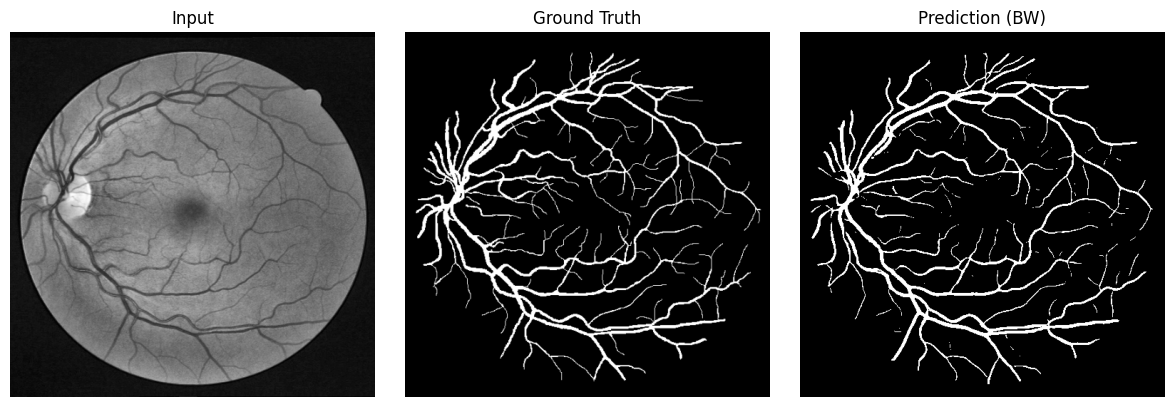

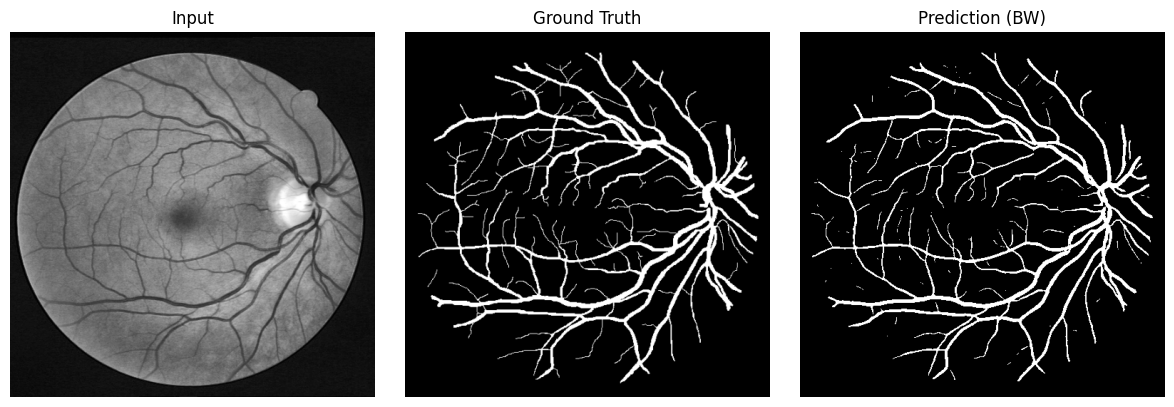

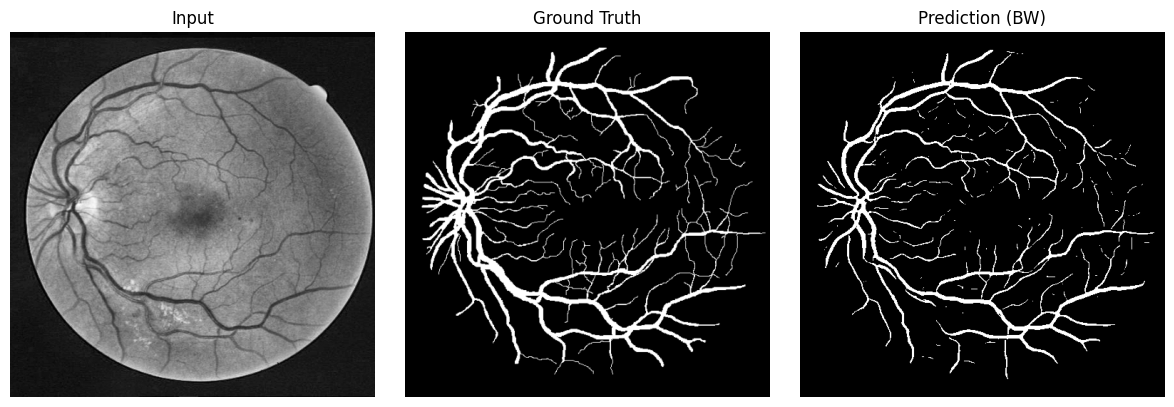

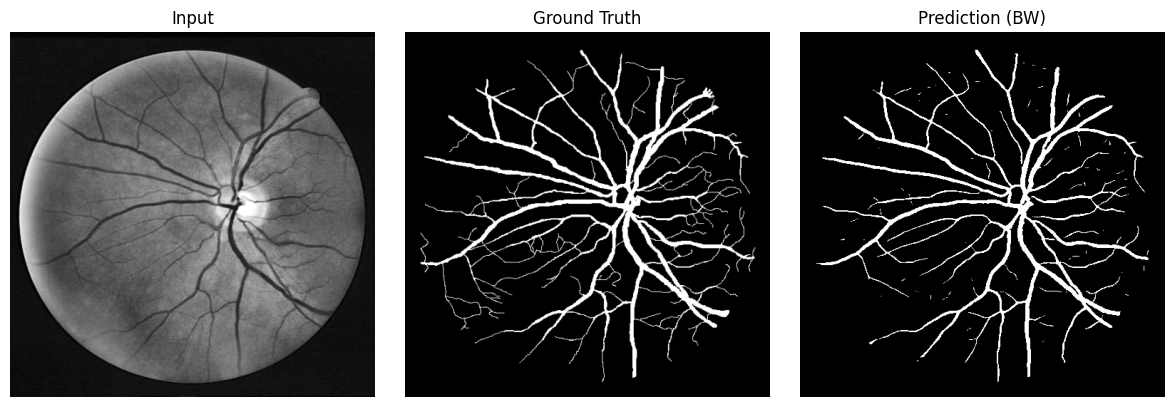

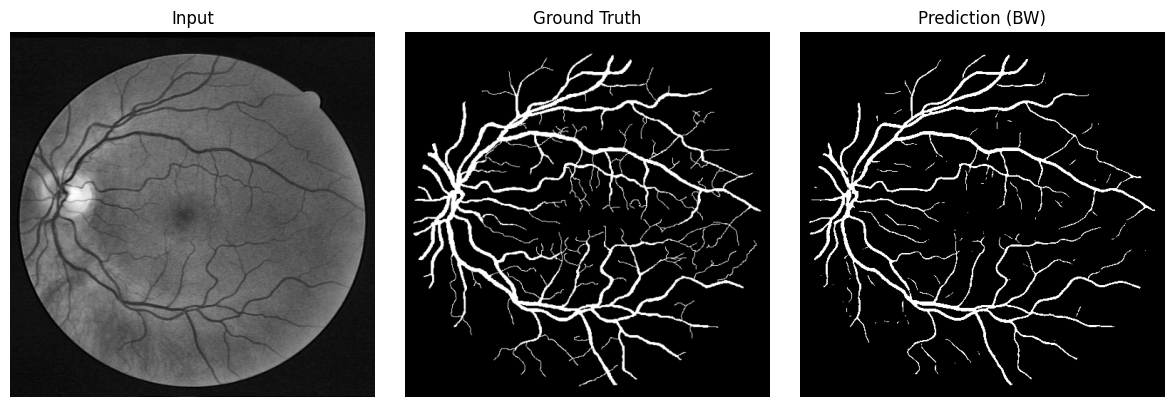

In [7]:
# -----------------------------------
# 6. Visualize Predictions
# -----------------------------------
import matplotlib.pyplot as plt

def display_results(i):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    # Input image
    axs[0].imshow(X_test[i].squeeze(), cmap='gray')
    axs[0].set_title("Input")
    axs[0].axis("off")
    # Ground truth mask
    axs[1].imshow(y_test[i].squeeze(), cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")
    # Predicted mask (binary)
    axs[2].imshow(preds_bin[i].squeeze(), cmap='gray')
    axs[2].set_title("Prediction (BW)")
    axs[2].axis("off")
    plt.tight_layout()
    plt.show()

# Display the first 5 test examples
for i in range(5):
    display_results(i)


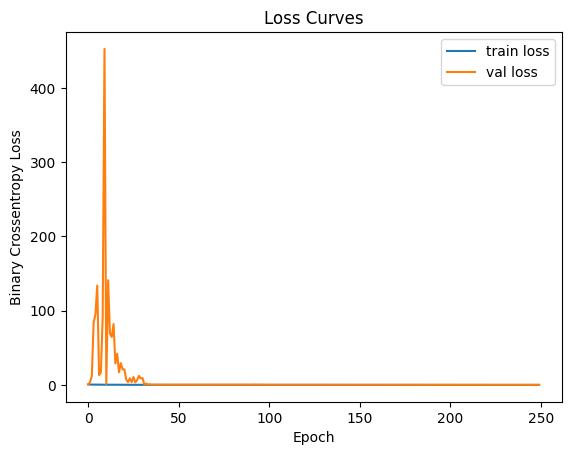

In [8]:
# -----------------------------------
# 7. Plot Training & Validation Loss
# -----------------------------------
import matplotlib.pyplot as plt

# assume `history` is the History object from model.fit
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.show()


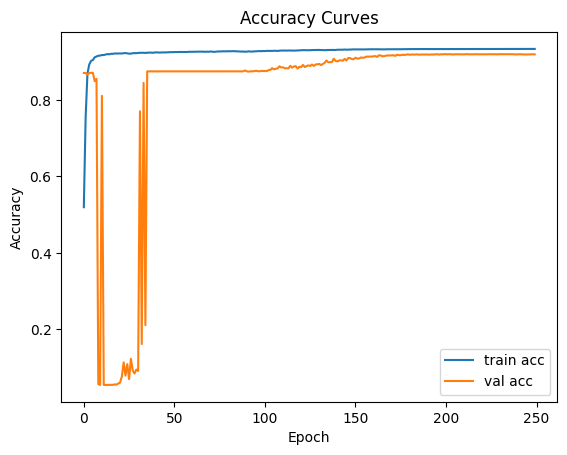

In [9]:
# -----------------------------------
# 8. Plot Training & Validation Accuracy
# -----------------------------------
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
